In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [17]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [3]:
# load data
os.chdir("/content/drive/My Drive/AIML_Projects/face_mask_segmentation/")
data = np.load("images.npy",allow_pickle=True)

In [4]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [5]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [6]:
# train n test

X_test=np.zeros((9,224,224,3))
mask=np.zeros((9,224,224))
x_train=np.zeros((400,224,224,3))
x_mask=np.zeros((400,224,224))
index=[]
j=0
k=0
for i in range(X_train.shape[0]):
  if i>=400:
    X_test[j]=X_train[i]
    mask[j]=masks[i]
    index.append(i)
    j+=1
  else:
    x_train[k]=X_train[i]
    x_mask[k]=masks[i]
    k+=1

In [7]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output
    block4 = model.get_layer("conv_pw_3_relu").output
    block5 = model.get_layer("conv_pw_1_relu").output
    block6 = model.get_layer("conv1_relu").output
   

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block4])
    x = Concatenate()([UpSampling2D()(x), block5])
    x = Concatenate()([UpSampling2D()(x), UpSampling2D()(block5)])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

In [8]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________________________

In [9]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())


In [10]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [11]:
model.compile(optimizer='adam',loss=loss,metrics=dice_coefficient)

In [12]:
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [13]:
model.fit(x=x_train,y=x_mask,epochs=50,batch_size=1,callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/50
400/400 [==============================] - ETA: 0s - loss: 1.2722 - dice_coefficient: 0.5005
Epoch 00001: loss improved from inf to 1.27224, saving model to model-1.27.h5
400/400 [==============================] - 45s 113ms/step - loss: 1.2722 - dice_coefficient: 0.5005 - lr: 0.0010
Epoch 2/50
400/400 [==============================] - ETA: 0s - loss: 0.8416 - dice_coefficient: 0.6030
Epoch 00002: loss improved from 1.27224 to 0.84156, saving model to model-0.84.h5
400/400 [==============================] - 45s 113ms/step - loss: 0.8416 - dice_coefficient: 0.6030 - lr: 0.0010
Epoch 3/50
400/400 [==============================] - ETA: 0s - loss: 0.7584 - dice_coefficient: 0.6372
Epoch 00003: loss improved from 0.84156 to 0.75840, saving model to model-0.76.h5
400/400 [==============================] - 45s 113ms/step - loss: 0.7584 - dice_coefficient: 0.6372 - lr: 0.0010
Epoch 4/50
400/400 [==============================] - ETA: 0s - loss: 0.6625 - dice_coefficient: 0.6746
Epo

In [14]:
model.save('face_detection.h5')

In [15]:
model.evaluate(X_test,mask,batch_size=10)

1/1 [==============================] - 0s 3ms/step - loss: 0.6414 - dice_coefficient: 0.6631


[0.6414114832878113, 0.6630793809890747]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


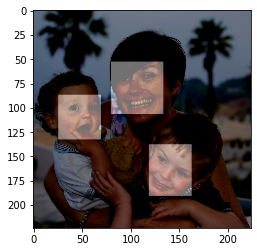

In [26]:
# Actual image
n = 0
plt.imshow(X_test[n])
plt.imshow(mask[n],cmap='gray',alpha=0.45)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


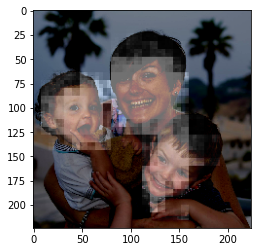

In [28]:
# test image
pred_mask = cv2.resize(model.predict(np.array([X_test[n]]))[0],(IMAGE_WIDTH,IMAGE_HEIGHT))
plt.imshow(X_test[n])
plt.imshow(pred_mask,cmap='gray',alpha=0.45)